# Weather

In [1]:
import helpers as hp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import normaltest
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine

from config import usr, pwd, url, port, db

%matplotlib inline

## Load Data
Load the dataset and inspect it's contents.

In [2]:
engine = create_engine(f"postgresql+psycopg2://{usr}:{pwd}@{url}:{port}/{db}")

In [3]:
query = f'''
SELECT
    *
FROM
    {db};
'''

In [4]:
df = pd.read_sql_query(query, con=engine)

In [5]:
engine.dispose()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


Only consider the following columns for this analysis.

In [7]:
columns = ['humidity', 'windspeed', 'windbearing', 'pressure', 'temperature']

In [8]:
df_subset = df.loc[:, columns].copy()

In [9]:
df_subset.describe().T

,count,mean,std,min,25%,50%,75%,max
humidity,96453.0,0.734899,0.195473,0.000000,0.600000,0.7800,0.890000,1.000000
windspeed,96453.0,10.810640,6.913571,0.000000,5.828200,9.9659,14.135800,63.852600
windbearing,96453.0,187.509232,107.383428,0.000000,116.000000,180.0000,290.000000,359.000000
pressure,96453.0,1003.235956,116.969906,0.000000,1011.900000,1016.4500,1021.090000,1046.380000
temperature,96453.0,11.932678,9.551546,-21.822222,4.688889,12.0000,18.838889,39.905556


In [10]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 5 columns):
humidity       96453 non-null float64
windspeed      96453 non-null float64
windbearing    96453 non-null float64
pressure       96453 non-null float64
temperature    96453 non-null float64
dtypes: float64(5)
memory usage: 3.7 MB


In [11]:
df_subset.corr()

,humidity,windspeed,windbearing,pressure,temperature
humidity,1.000000,-0.224951,0.000735,0.005454,-0.632255
windspeed,-0.224951,1.000000,0.103822,-0.049263,0.008957
windbearing,0.000735,0.103822,1.000000,-0.011651,0.029988
pressure,0.005454,-0.049263,-0.011651,1.000000,-0.005447
temperature,-0.632255,0.008957,0.029988,-0.005447,1.000000


## Data Cleaning
### Missting values
There are not missing values

### Outliers
#### Standardize dataset

In [12]:
scaler = StandardScaler()
standardized = scaler.fit_transform(df_subset)

In [13]:
df_standardized = pd.DataFrame(standardized)
df_standardized.columns = df_subset.columns

In [14]:
df_standardized.describe().T

,count,mean,std,min,25%,50%,75%,max
humidity,96453.0,-8.368600e-17,1.000005,-3.759618,-0.690120,0.230729,0.793470,1.356212
windspeed,96453.0,4.249127e-16,1.000005,-1.563692,-0.720679,-0.122186,0.480964,7.672191
windbearing,96453.0,-9.517809e-17,1.000005,-1.746175,-0.665928,-0.069930,0.954442,1.597003
pressure,96453.0,-1.390838e-16,1.000005,-8.576917,0.074071,0.112970,0.152639,0.368849
temperature,96453.0,-2.251271e-16,1.000005,-3.533991,-0.758393,0.007048,0.723050,2.928638


#### Look for outliers

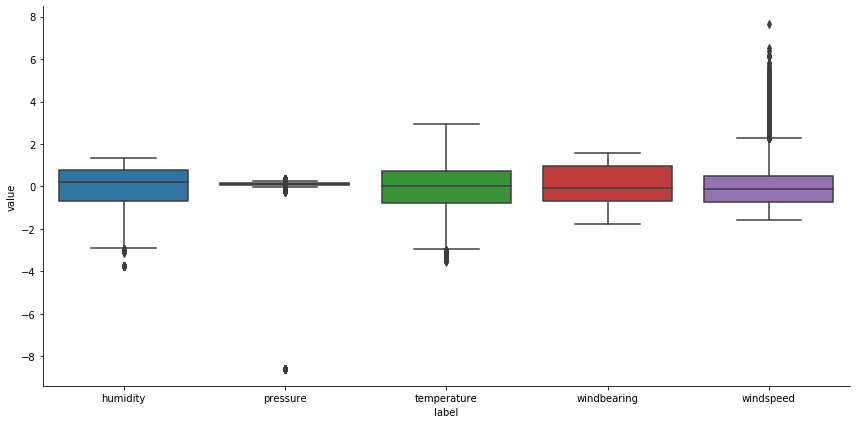

In [15]:
hp.look_for_outliers(df_standardized, df_standardized.columns.tolist())

Correct for outliers using Tukey.

In [16]:
columns = df_standardized.columns.tolist()
tukey_columns = [f'{x}_tk' for x in columns]
df_standardized = hp.correct_outliers(df_standardized, columns)

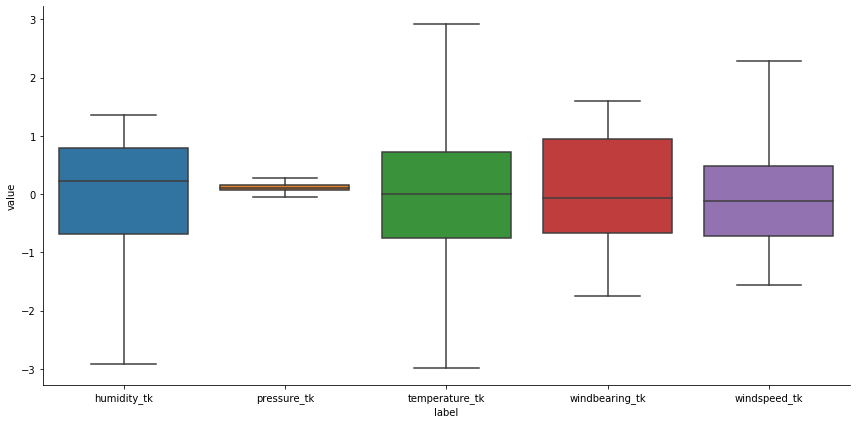

In [17]:
hp.look_for_outliers(df_standardized, tukey_columns)

## Data Exploration
### Correlations
Inspect correlations between features and target variable.

In [18]:
df_standardized.loc[:, tukey_columns].corr()

,humidity_tk,windspeed_tk,windbearing_tk,pressure_tk,temperature_tk
humidity_tk,1.000000,-0.230558,0.000591,0.039712,-0.633371
windspeed_tk,-0.230558,1.000000,0.099996,-0.247397,0.015327
windbearing_tk,0.000591,0.099996,1.000000,-0.079058,0.029996
pressure_tk,0.039712,-0.247397,-0.079058,1.000000,-0.295976
temperature_tk,-0.633371,0.015327,0.029996,-0.295976,1.000000


In [19]:
df_correlations = df_standardized.loc[:, tukey_columns].corr().copy()

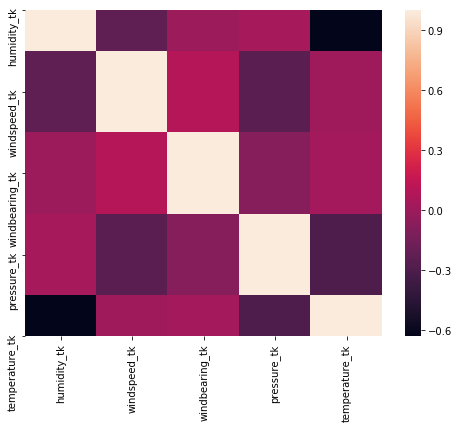

In [20]:
f, axes = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(df_correlations, ax=axes)
plt.show()

**Observations:**  Humidity and temperature are highly correlated.

## Modeling

In [21]:
df_model = df_standardized.loc[:, tukey_columns].copy()

In [22]:
tukey_columns

['humidity_tk',
 'windspeed_tk',
 'windbearing_tk',
 'pressure_tk',
 'temperature_tk']

In [23]:
features = ['humidity_tk', 'windspeed_tk', 'windbearing_tk', 'pressure_tk']
X = df_model.loc[:, features]
y = df_model['temperature_tk']

lrm = linear_model.LinearRegression()

lrm.fit(X, y)

print(f'Coefficients: {lrm.coef_}')
print(f'Intercept: {lrm.intercept_}')

# Make predictions
y_pred = lrm.predict(X)

# Compute errors between actual values and predictions
errors = y - y_pred

Coefficients: [-0.67202523 -0.23806103  0.02711614 -4.87500124]
Intercept: 0.5502004128715433


## Model Evaluation
### Linearity of model coefficients

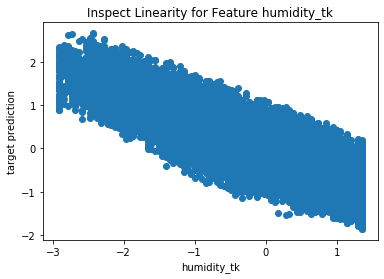

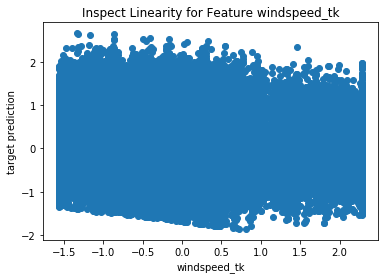

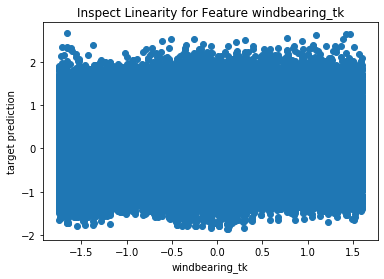

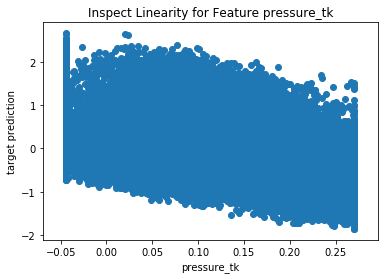

In [24]:
hp.check_feature_linearity(df_model, features, y_pred)

**Observations** The relationships between the features and the predictions do look linear.

### Average errors

In [25]:
print(f'The average error is {errors.mean()}.')

The average error is 5.1861744681358853e-17.


**Observations:** The average error is zero.

### Homoscedasticity

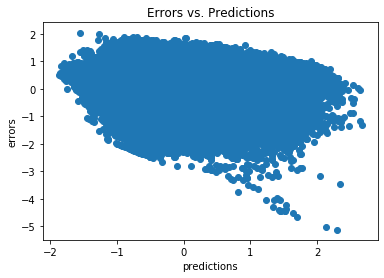

The Bartlett test is 128.0603517145497, with a p-value of 1.0888125744733136e-29.
The Levine test is 98.15445051216022, with a p-value of 3.919497574632673e-23.


In [26]:
hp.check_homoscedasticity(y_pred, errors)

**Observation:** Both the Bartlett test and the Levine test indicate that there is a large amount of heteroscedacity in the model.

### Multicolinearity

In [27]:
df_model.loc[:, features].corr()

,humidity_tk,windspeed_tk,windbearing_tk,pressure_tk
humidity_tk,1.000000,-0.230558,0.000591,0.039712
windspeed_tk,-0.230558,1.000000,0.099996,-0.247397
windbearing_tk,0.000591,0.099996,1.000000,-0.079058
pressure_tk,0.039712,-0.247397,-0.079058,1.000000


**Observations:** All features have low correlations with eachother. Therefore, colinearity is not an issue.

### Error correlations

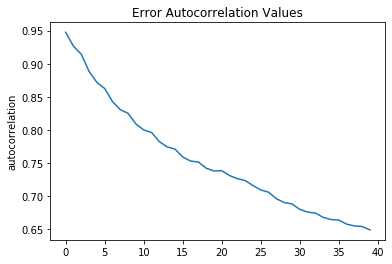

Max autocorrelation: 0.948
Min autocorrelation: 0.649


In [28]:
hp.check_error_autocorrelation(errors)

**Observations:** There is a high degree of autocorrelation in the model.

### Error and feature correlations

In [29]:
df_model['errors'] = errors

In [30]:
df_model.corr()['errors']

humidity_tk      -6.501297e-16
windspeed_tk      1.814675e-16
windbearing_tk   -4.442382e-17
pressure_tk       5.278224e-16
temperature_tk    6.941089e-01
errors            1.000000e+00
Name: errors, dtype: float64

**Observations:** The correlations are almost zero between the errors and the features.